# Etudiantes
Lina Berroug
et
Jessica Karega

In [24]:
#IMPORTATION DE MODULES

import json
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os



In [25]:
# Télécharger les stopwords en français si ce n'est pas déjà fait
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lnberroug/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lnberroug/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lnberroug/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
themes = {
    "Technologie": ["smartphone", "ai", "artificial", "intelligence", "tesla", "5g", "autonomous", "future", "vehicle", "robot", "machine", "algorithm", "data", "programming"],
    "Sports": ["gold", "olympics", "champions", "league", "serena", "athletes", "football", "team", "match", "qualifiers", "score", "tournament", "basketball", "goal"],
    "Santé": ["mental", "health", "vaccination", "fasting", "diet", "exercise", "life", "disease", "awareness", "nutrition", "wellness", "hospital", "doctor", "medicine"],
    "Divertissement": ["adele", "album", "marvel", "movie", "series", "netflix", "oscars", "swift", "tour", "boxoffice", "music", "concert", "theater", "festival"],
    "Politique": ["election", "government", "policy", "minister", "law", "debate", "vote", "campaign", "president", "parliament", "senate", "democracy"],
    "Économie": ["market", "stock", "economy", "finance", "investment", "growth", "business", "trade", "money", "tax", "employment", "entrepreneur"],
    "Éducation": ["school", "university", "student", "teacher", "class", "learning", "exam", "homework", "course", "degree", "education", "knowledge", "scholarship"],
    "Climat": ["climate", "global", "warming", "environment", "sustainability", "pollution", "green", "renewable", "recycle", "weather", "carbon", "planet", "biodiversity"],
    "Voyages": ["travel", "trip", "vacation", "flight", "hotel", "destination", "adventure", "explore", "tourism", "cruise", "passport", "beach", "holiday"],
    "Cuisine": ["recipe", "dish", "meal", "cooking", "baking", "chef", "restaurant", "kitchen", "ingredients", "food", "menu", "flavor", "dinner", "lunch"]
}

with open('test2.json', 'r', encoding='utf-8') as f:
    donne = json.load(f)

# Introduction
Ce notebook analyse les tweets d'un fichier JSON pour extraire des informations et les exploiter grâce à un dataFrame

Nous utiliserons les bibliothèques suivantes :
- `json` : pour manipuler les fichiers JSON
- `pandas` : pour analyser les données tabulaires
- `re` : pour extraire ou supprimer des expressions régulière d'un tweet
- `TextBlob` : pour l'analyse de sentiments
- `matplotlib` : pour visualiser sous forme de graphiques les données


### Diagramme des étapes de traitement
Schéma qui montre les étapes suivies pour le projet :

<img src="diagramme.png" alt="Description de l'image" style="width:40%; height:auto;">




# <u>**PARTIE I** : Création de la classe Tweet et sa soumission dans la Landing Zone</u>

## Création de la classe Tweet
-  Nettoyer le texte brut.


## Création de la classe ZA
- Enrichir et structurer les données nettoyées.

    ### 1. Méthode : Extraction_Hashtags 
    - on utilise une regex pour extraire des hashtags standards 
    ### 2. Méthode : Extraction_Mentions 
    - on utilise une regex pour renvoyer toutes les correspondances d'un motif (mentions @) sous forme de liste.
    ### 3. Méthode : Extraction_Sentiments
    - on utilise Textblob pour déterminer le sentiment d'un texte en renvoyant une polarité (positive, neutre, négative) et une subjectivité.
    ### 4. Méthode : Id_Topic


## Création Zone d'Atterissage




In [27]:
#PARTIE : CREATION DU TWEET + SOUMISSION DU TWEET DANS LANDING ZONE

#Création d'une Classe Tweet à laquelle seront associées les attributs suivant : auteurs, hashtag, mentions, sentiments, (topics???)

class Tweet: #Plan/Modèle
    def __init__(self, contenu): #Méthode (assisstant qui aide à donner à chaque tweet ses attributs)
        self.contenu = contenu

    def Nettoyage_Tweet(self):
        """Fonction qui supprime les caractères spéciaux d'un tweet"""
        enlever_speciaux = re.sub(r'[^a-zA-Z0-9\s@#]', '', self.contenu)
        return enlever_speciaux

class ZA:
    def __init__(self, id, auteur, texte): #Méthode (assisstant qui aide à donner à chaque tweet ses attributs)
        self.id = id
        self.auteur = auteur
        self.text = texte
        self.hashtags = self.Extraction_Hashtags()
        self.mentions = self.Extraction_Mentions()
        self.sentiment = self.Extraction_Sentiments()
        self.closest_theme = self.Id_Topic()

    
    def Extraction_Sentiments(self): 
        """Extrait le sentiment du texte"""
        blob = TextBlob(self.text)
        polarite =  blob.sentiment.polarity
        if polarite > 0:
            sentiment = 'positif'
        elif polarite < 0:
            sentiment = 'négatif'
        elif polarite == 0:
            sentiment = 'neutre'
        return sentiment
    
    def Extraction_Hashtags(self):  #A Faire 
        """"""
        hashtags = re.findall(r'#\w+', self.text)
        return hashtags
    
    def Extraction_Mentions(self):  #A Faire
        """Fonction qui extrait les mentions de personnes dans un tweet"""
        mentions = re.findall(r'@[A-Za-z0-9_]+', self.text)

        return mentions


    def Id_Topic(self):
        
        # Fonction pour nettoyer le texte
        def traitement_texte(text):
            text = text.lower()  # Convertir en minuscule
            text = re.sub(r'[^a-z\s]', '', text)  # Supprimer les caractères spéciaux
            return text

        def get_stopwords():
            return stopwords.words('french')

        stopwords_list = get_stopwords()
        tweets = [infos["text"] for infos in donne]

        # Nettoyer les textes des tweets
        texte_traite = [traitement_texte(tweet) for tweet in tweets]

        # Initialiser et entraîner le vecteur TF-IDF
        vecteur = TfidfVectorizer(stop_words=stopwords_list)
        a = vecteur.fit_transform(texte_traite)

        # Entraîner le modèle LDA
        lda = LatentDirichletAllocation(n_components=20, random_state=42)
        lda.fit(a)

        # Récupérer les topics
        topics = []
        words = vecteur.get_feature_names_out()
        for i, topic_weights in enumerate(lda.components_):
            top_indices = topic_weights.argsort()[:-6:-1]  # Prendre les 2 mots les plus importants
            top_words = [words[i] for i in top_indices]
            topics.append(top_words)

        # Prédire le topic pour le tweet donné
        tweet_traite = traitement_texte(self.text)
        vecteur_tweet = vecteur.transform([tweet_traite])
        probabilities = lda.transform(vecteur_tweet)
        topic_idx = probabilities.argmax()  # Trouver l'indice du topic avec la probabilité la plus élevée
        topic_words = topics[topic_idx]  # Mots principaux du topic

        # Identifier le thème principal
        theme_scores = {}
        for theme, keywords in themes.items():
            common_words = set(topic_words).intersection(set(keywords))
            theme_scores[theme] = len(common_words)

        # Ajouter un thème "Inconnu" si aucun mot ne correspond
        if max(theme_scores.values()) == 0:
            closest_theme = "Inconnu"
        else:
            closest_theme = max(theme_scores, key=theme_scores.get)  # Trouver le thème avec le plus grand score

        return closest_theme

def Zone_Atterisssage (Fichier):
        """Stockage du tweet dans le fichier JSON zone d'atterissage"""
        ZA_liste=[]

        repertoire_courant = os.getcwd()
        fichier_entrant = os.path.join(repertoire_courant, Fichier)
        fichier_sortant = os.path.join(repertoire_courant, 'outputs', 'ZA.json')
        
        with open (fichier_entrant,'r',encoding='utf-8') as f:
            donnee= json.load(f)
            
        for infos_tweets in donnee:
            id = infos_tweets.get("id")
            auteur = infos_tweets.get("author_id")
            contenu = infos_tweets.get("text")

            tweet = Tweet(contenu)
            contenu_nettoye = tweet.Nettoyage_Tweet()
    

            tweet_analyse = ZA(id, auteur, contenu_nettoye)


            dict_tweet = {
                "id": tweet_analyse.id,
                "auteur": tweet_analyse.auteur,
                "tweet": contenu_nettoye,
                "texte": tweet_analyse.text,
                "hashtags" : tweet_analyse.hashtags,
                "mentions" : tweet_analyse.mentions,
                "sentiment" : tweet_analyse.sentiment
            }
            ZA_liste.append(dict_tweet)

        
        os.makedirs(os.path.dirname(fichier_sortant), exist_ok=True)
        with open(fichier_sortant,'w', encoding='utf-8') as f:
            json.dump(ZA_liste, f, indent=4, ensure_ascii=False)
            
if __name__ == "__main__":
    Zone_Atterisssage('test2.json')




# <u>**PARTIE II** : Data Frame et Visualisation des données</u>

## Création de la DF
- structure qui organise les données en tables bidimensionnelles de lignes et de colonnes, comparables à une feuille de calcul


## Fonction d'analyses avancées
        - Top K éléments : 
        - Publications_par_hashtag : 
        - Publications_par_utilisateurs : 
        - publications_par_topic : 
        - tweets_par_utilisateur : 


## Fonction de Visualisation sur Maplotlib


In [28]:
#DATAFRAME
def CreerDataFrame(fichier_json):
    df  = pd.read_json(fichier_json)
    return df

#Analyses avancées 

def Top_K_element(df, colonne, k=3):
    """
    Retourne les K éléments les plus fréquents dans une colonne donnée.
    """
    top_k = df[colonne].explode().value_counts().head(k) #a méthode .explode() transforme chaque élément d'une liste dans une ligne distincte.
    element= top_k.index.tolist()  # Liste des hashtags
    counts = top_k.values.tolist()
    return element,counts

def publications_par_hashtag(df):
    """
    Retourne le nombre de publications par hashtag.
    """
    hashtags_explodes = df['hashtags'].explode()
    hashtag_counts = hashtags_explodes.value_counts()

    hashtags = hashtag_counts.index.tolist()  # Liste des hashtags
    counts = hashtag_counts.values.tolist()   # Liste des nombres d'occurrences
    return hashtags, counts

def publications_par_utilisateurs(df):
    """
    Retourne le nombre de publications par utilisateur.
    """
    utilisateur_counts = df['auteur'].value_counts()
    utilisateur = utilisateur_counts.index.tolist()  # Liste des utilisateurs
    counts = utilisateur_counts.values.tolist()   # Liste des nombres d'occurrences
    return utilisateur, counts

def publications_par_topic(df):
    """
    Retourne le nombre de publications par topics.
    """
    topics_counts = df['topics'].value_counts()
    topic = topics_counts.index.tolist()  # Liste des topics
    counts = topics_counts.values.tolist()   # Liste des nombres d'occurrences
    return topic , counts

def tweets_par_utilisateur(df,utilisateur):
    """
    Retourne le nombre de publications par utilisateurs.
    """
    filtre = df[df['auteur'] == utilisateur]
    tweets = filtre['contenu'].tolist() 
    utilisateurs = filtre ['auteur'].tolist() 
    return utilisateurs,tweets
    


if __name__ == "__main__":
    dossier_projet = os.getcwd()  # Répertoire actuel
    fichier_json = os.path.join(dossier_projet, 'outputs', 'ZA.json')  # Créer un chemin relatif


    try:
        df = CreerDataFrame(fichier_json)
        
    except FileNotFoundError as e:
        print(e)



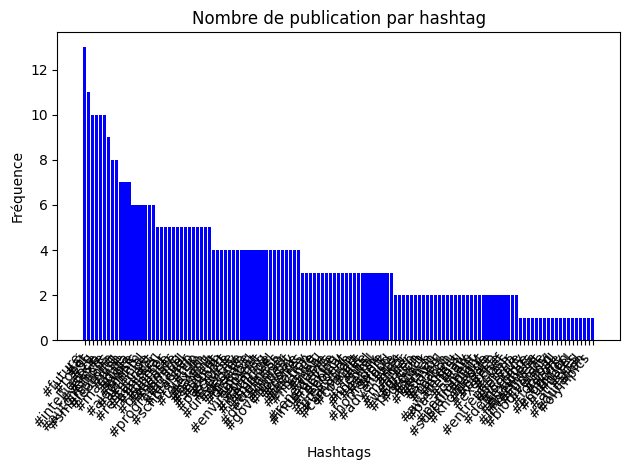

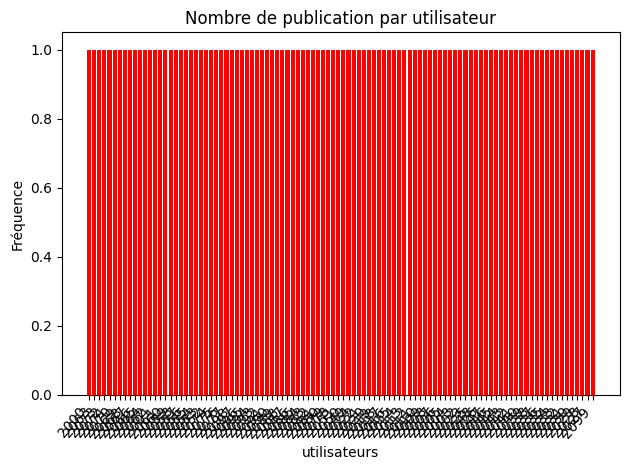

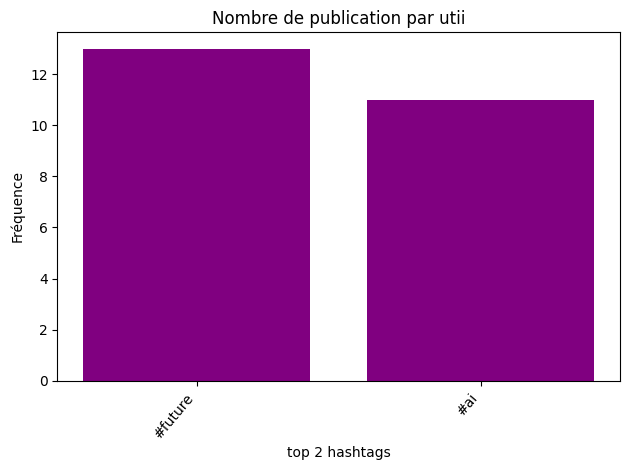

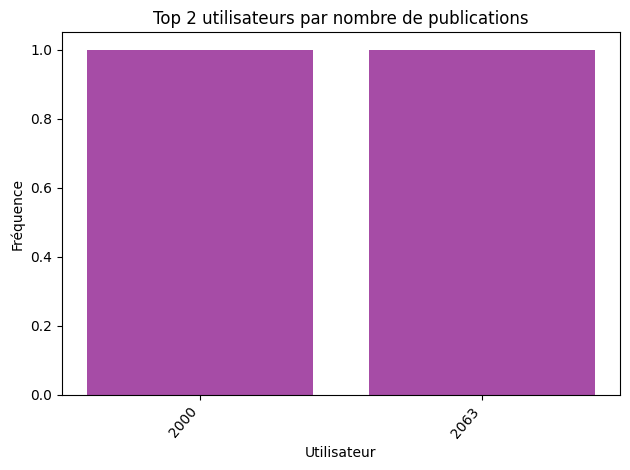

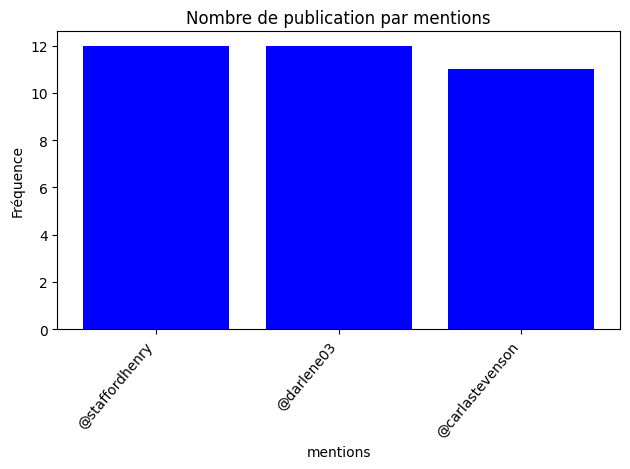

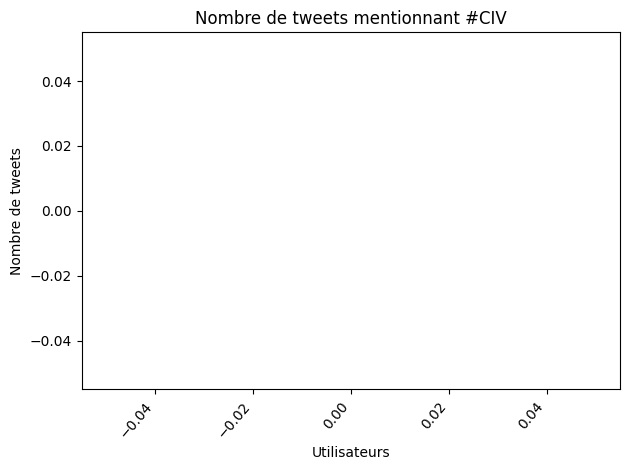

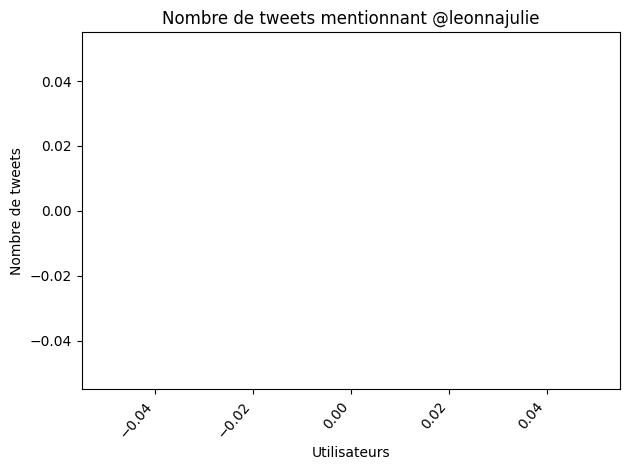

In [29]:
# Visualisation des résultats


def nbr_hashtag(df):
    hashtags, counts = publications_par_hashtag(df)
    plt.bar(hashtags,counts, color = 'blue')
    plt.title("Nombre de publication par hashtag")
    plt.xlabel("Hashtags")
    plt.ylabel("Fréquence")
    plt.xticks(rotation=50, ha='right')
    plt.tight_layout()
    plt.show()

def nbr_utilisateur(df):
    """
    Visualise les utilisateurs publications.
    """
    utilisateur, counts = publications_par_utilisateurs(df)
    
    # Convertir les utilisateurs en chaînes de caractères
    utilisateur = [str(u) for u in utilisateur]

    plt.bar(utilisateur,counts, color = 'red')
    plt.title("Nombre de publication par utilisateur")
    plt.xlabel("utilisateurs")
    plt.ylabel("Fréquence")
    plt.xticks(rotation=50, ha='right')
    plt.tight_layout()
    plt.show()

def nbr_topic(df):
    """
    Visualise les topics publications.
    """
    topic, counts = publications_par_topic(df)
    plt.bar(topic,counts, color = 'rouge')
    plt.title("Nombre de publication par topic")
    plt.xlabel("topics")
    plt.ylabel("Fréquence")
    plt.xticks(rotation=50, ha='right')
    plt.tight_layout()
    plt.show()

def top_hashtags(df, k):
    """
    Visualise les Top hashtags.
    """
    element,counts = Top_K_element(df, 'hashtags', k)
    plt.bar(element,counts, color = 'purple')
    plt.title("Nombre de publication par utii")
    plt.xlabel(f"top {k} hashtags")
    plt.ylabel("Fréquence")
    plt.xticks(rotation=50, ha='right')
    plt.tight_layout()
    plt.show()

def top_topic(df,k):
    """
    Visualise les Top Topics.
    """
    element,counts = Top_K_element(df, 'topic', k)
    plt.bar(element,counts, color = 'blue')
    plt.title("Nombre de publications par hashtag")
    plt.xlabel('topics')
    plt.ylabel("Fréquence")
    plt.xticks(rotation=50, ha='right')
    plt.tight_layout()
    plt.show()

def top_auteur(df,k):
    """
    Visualise les Top utilisateurs.
    """
    if 'auteur' not in df.columns:
        raise ValueError("La colonne 'auteur' n'existe pas dans le DataFrame.")
    
    element, counts = Top_K_element(df, 'auteur', k)
    
    element = [str(e) for e in element]

    plt.bar(element, counts, color='purple', alpha=0.7)
    plt.title(f"Top {k} utilisateurs par nombre de publications")
    plt.xlabel("Utilisateur")
    plt.ylabel("Fréquence")
    plt.xticks(rotation=50, ha='right')  # Ajustez la rotation et la taille
    plt.tight_layout()  # Ajustez les marges pour éviter les débordements
    plt.show()

def top_mentions(df,k):
    """
    Visualise les Top mentions.
    """
    element,counts = Top_K_element(df, 'mentions', k)
    plt.bar(element,counts, color = 'blue')
    plt.title("Nombre de publication par mentions")
    plt.xlabel('mentions')
    plt.ylabel("Fréquence")
    plt.xticks(rotation=50, ha='right')
    plt.tight_layout()
    plt.show()


def utilisateurs_mentions_hashtag(df, hashtag):
    """
    Visualise les utilisateurs qui mentionnent un hashtag spécifique.
    """
    # Filtrer les tweets contenant le hashtag
    tweets = df[df['hashtags'].apply(lambda hashtags: hashtag in hashtags if isinstance(hashtags, list) else False)]

    utilisateurs_count = tweets['auteur'].value_counts()

    # Convertir les indices (utilisateurs) en chaînes pour éviter les problèmes d'affichage
    utilisateurs = [str(u) for u in utilisateurs_count.index]


    plt.bar(utilisateurs, utilisateurs_count.values, color='green')
    plt.title(f"Nombre de tweets mentionnant {hashtag}")
    plt.xlabel("Utilisateurs")
    plt.ylabel("Nombre de tweets")
    plt.xticks(rotation=50, ha='right')
    plt.tight_layout()
    plt.show()

def utilisateur_mentions_utilisateur(df, mention):
    """
    Visualise les utilisateurs mentionnés par un utilisateur spécifique.
    """
    #Filtre Les tweet contenant la mention
    tweets = df[df['mentions'].apply(lambda mentions: mention in mentions if isinstance(mentions,list) else False )]

    utilisateurs_count = tweets['auteur'].value_counts()

    utilisateurs = [str(u) for u in utilisateurs_count.index]


    plt.bar(utilisateurs, utilisateurs_count.values, color='green')
    plt.title(f"Nombre de tweets mentionnant {mention}")
    plt.xlabel("Utilisateurs")
    plt.ylabel("Nombre de tweets")
    plt.xticks(rotation=50, ha='right')
    plt.tight_layout()
    plt.show()

def utilisateurs_mentionnes_par_utilisateur(df, utilisateur):
    """
    Visualise les utilisateurs mentionnés par un utilisateur spécifique.
    """

    df['auteur'] = df['auteur'].astype(str)

    # Filtrer les tweets de l'utilisateur donné
    tweets_utilisateur = df[df['auteur'] == utilisateur]

    if tweets_utilisateur.empty:
        return

    mentions = tweets_utilisateur['mentions'].explode()

    if mentions.empty:
        return

    mentions_count = mentions.value_counts()

    mentions_index = [str(m) for m in mentions_count.index]

    plt.bar(mentions_index, mentions_count.values, color='purple')
    plt.title(f"Utilisateurs mentionnés par '{utilisateur}'")
    plt.xlabel("Utilisateurs mentionnés")
    plt.ylabel("Nombre de mentions")
    plt.xticks(rotation=50, ha='right')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    repertoire_courant = os.getcwd()
    fichier_json = os.path.join(repertoire_courant, "outputs", "ZA.json")
    df = CreerDataFrame(fichier_json)

    nbr_hashtag(df)
    nbr_utilisateur(df)
    #nbr_topic(df) #A revoir
    top_hashtags(df, 2)
    top_auteur(df,2)
    top_mentions(df,3)
    utilisateurs_mentions_hashtag(df,"#CIV")
    utilisateur_mentions_utilisateur(df, '@leonnajulie')
    utilisateurs_mentionnes_par_utilisateur(df, '372993152')

    

In [30]:
t= "@ericbailly24 @maxigr04del  mes tontons vous avez fait votre part , JO prochain on ira en demi final au moins. BRAVO à vous . #SupportriceMazo #domie #CIV"


def Nettoyage_Tweet(tweet):
    """Fonction qui supprime les caractères spéciaux d'un tweet"""
    enlever_speciaux = re.sub(r'[^a-zA-Z0-9\s@#]', '', tweet)
    return enlever_speciaux

def Extraction_Sentiments(tweet): 
        """Extrait le sentiment du texte"""
        blob = TextBlob(tweet)
        polarite =  blob.sentiment.polarity
        if polarite > 0:
            sentiment = 'positif'
        elif polarite < 0:
            sentiment = 'négatif'
        elif polarite == 0:
            sentiment = 'neutre'
        return sentiment
    
def Extraction_Hashtags(tweet):  #A Faire 
        """"""
        hashtags = re.findall(r'#\w+', tweet)
        return hashtags
    
def Extraction_Mentions(tweet):  #A Faire
        """Fonction qui extrait les mentions de personnes dans un tweet"""
        mentions = re.findall(r'@[A-Za-z0-9_]+', tweet)
        return mentions


print(Nettoyage_Tweet(t))
print(Extraction_Sentiments(t))
print(Extraction_Hashtags(t))
print(Extraction_Mentions(t))




@ericbailly24 @maxigr04del  mes tontons vous avez fait votre part  JO prochain on ira en demi final au moins BRAVO  vous  #SupportriceMazo #domie #CIV
neutre
['#SupportriceMazo', '#domie', '#CIV']
['@ericbailly24', '@maxigr04del']


In [42]:
import json

with open ('test2.json','r',encoding='utf-8') as f:
    donne= json.load(f)

def Id_Topic(tweet):

    def traitement_texte(text):
        text= text.lower() # mettre en minuscule
        text= re.sub(r'[^a-z\s]', '', text) 
        return text
    def get_stopwords():
        return stopwords.words('english')
    stopwords_list = get_stopwords()
    tweets= []

        
    tweets = [infos["text"] for infos in donne]
        
    texte_traite = [traitement_texte(tweet) for tweet in tweets]
        
    vecteur = TfidfVectorizer(stop_words= stopwords_list)  # Utilise les stopwords en français intégrés dans sklearn
    a = vecteur.fit_transform(texte_traite)

    # n_components=2 : Le modèle cherchera à identifier 2 sujets principaux dans les données textuelles.
    lda = LatentDirichletAllocation(n_components=10, random_state=42)
    lda.fit(a) # on utilise LDA sur la matrice X 

    topics = []
    # Récupération du vocabulaire extrait par TfidfVectorizer
    words = vecteur.get_feature_names_out()
    for i, topic_weights in enumerate(lda.components_):
        top_indices = topic_weights.argsort()[:-3:-1]  # Prendre les 2 mots les plus importants
        top_words = [words[i] for i in top_indices]  # Utilisation des indices pour récupérer les mots correspondants dans la liste `words`.
        topics.append(f": {', '.join(top_words)}")

    tweet_traite = traitement_texte(tweet)
    vecteur_tweet = vecteur.transform([tweet_traite])
    probabilities = lda.transform(vecteur_tweet)
    topic_idx = probabilities.argmax()  # Trouve l'indice du topic avec la probabilité la plus élevée

    print(f"Le tweet :\n{tweet}\nAppartient au Topic {topics[topic_idx ]}")

tweet ="Discussing cuisine topics like food, baking, restaurant, chef"

Id_Topic(tweet)


Le tweet :
Discussing cuisine topics like food, baking, restaurant, chef
Appartient au Topic : dish, recipe
